# Rentfaster Data Analysis 

This notebook will analysis and visualize data taken from https://www.rentfaster.ca/ in order to predict rental prices of properties across Canada.

In [2]:
# imports

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LassoCV


## Loading and Exploring Data

In [4]:
df = pd.read_csv("rentfaster.csv")

In [5]:
df

,rentfaster_id,city,province,address,latitude,longitude,lease_term,type,price,beds,baths,sq_feet,link,furnishing,availability_date,smoking,cats,dogs
0,468622,Airdrie,Alberta,69 Gateway Dr NE,51.305962,-114.012515,Long Term,Townhouse,2495.0,2 Beds,2.5,1403,/ab/airdrie/rentals/townhouse/2-bedrooms/pet-f...,Unfurnished,Immediate,Non-Smoking,True,True
1,468622,Airdrie,Alberta,69 Gateway Dr NE,51.305962,-114.012515,Long Term,Townhouse,2695.0,3 Beds,2.5,1496,/ab/airdrie/rentals/townhouse/2-bedrooms/pet-f...,Unfurnished,Immediate,Non-Smoking,True,True
2,468622,Airdrie,Alberta,69 Gateway Dr NE,51.305962,-114.012515,Long Term,Townhouse,2295.0,2 Beds,2.5,1180,/ab/airdrie/rentals/townhouse/2-bedrooms/pet-f...,Unfurnished,Immediate,Non-Smoking,True,True
3,468622,Airdrie,Alberta,69 Gateway Dr NE,51.305962,-114.012515,Long Term,Townhouse,2095.0,2 Beds,2.5,1403,/ab/airdrie/rentals/townhouse/2-bedrooms/pet-f...,Unfurnished,18-Nov,Non-Smoking,True,True
4,468622,Airdrie,Alberta,69 Gateway Dr NE,51.305962,-114.012515,Long Term,Townhouse,2495.0,2 Beds,2.5,1403,/ab/airdrie/rentals/townhouse/2-bedrooms/pet-f...,Unfurnished,Immediate,Non-Smoking,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25766,334285,Yorkton,Saskatchewan,18 Allanbrooke Dr,51.203024,-102.484782,Long Term,Apartment,920.0,Studio,1,400,/sk/yorkton/rentals/apartment/3-bedrooms/pet-f...,Unfurnished,Immediate,Non-Smoking,True,True
25767,334285,Yorkton,Saskatchewan,18 Allanbrooke Dr,51.203024,-102.484782,Long Term,Apartment,1450.0,3 Beds,1,810,/sk/yorkton/rentals/apartment/3-bedrooms/pet-f...,Unfurnished,Immediate,Non-Smoking,True,True
25768,334284,Yorkton,Saskatchewan,363 Northview Rd,51.202667,-102.485765,Long Term,Apartment,1125.0,1 Bed,1,520,/sk/yorkton/rentals/apartment/1-bedroom/pet-fr...,Unfurnished,Immediate,Non-Smoking,True,True
25769,334284,Yorkton,Saskatchewan,363 Northview Rd,51.202667,-102.485765,Long Term,Apartment,920.0,Studio,1,400,/sk/yorkton/rentals/apartment/1-bedroom/pet-fr...,Unfurnished,Immediate,Non-Smoking,True,True


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25771 entries, 0 to 25770
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   rentfaster_id      25771 non-null  int64  
 1   city               25771 non-null  object 
 2   province           25771 non-null  object 
 3   address            25646 non-null  object 
 4   latitude           25771 non-null  float64
 5   longitude          25771 non-null  float64
 6   lease_term         25725 non-null  object 
 7   type               25771 non-null  object 
 8   price              25771 non-null  float64
 9   beds               25639 non-null  object 
 10  baths              25637 non-null  object 
 11  sq_feet            21659 non-null  object 
 12  link               25771 non-null  object 
 13  furnishing         25771 non-null  object 
 14  availability_date  25759 non-null  object 
 15  smoking            23069 non-null  object 
 16  cats               255

In [7]:
df.describe()

,rentfaster_id,latitude,longitude,price
count,25771.000000,25771.000000,25771.000000,25771.000000
mean,471913.795274,48.903370,-100.332196,2151.624142
std,120330.335865,3.603257,17.917001,972.820941
min,820.000000,40.741802,-128.661880,0.000000
25%,415749.000000,45.418785,-114.074660,1600.000000
50%,522379.000000,50.913739,-113.513905,2045.000000
75%,563397.500000,51.093585,-79.401311,2550.000000
max,572635.000000,62.459246,-52.695472,29990.000000


In [8]:
df.isnull().sum()

rentfaster_id           0
city                    0
province                0
address               125
latitude                0
longitude               0
lease_term             46
type                    0
price                   0
beds                  132
baths                 134
sq_feet              4112
link                    0
furnishing              0
availability_date      12
smoking              2702
cats                  173
dogs                  173
dtype: int64

## Data Cleaning, Prep, and Visuals

In [10]:
# I think we can drop a few of these less valuable columns but for now we can drop nan from these columns

df.dropna(subset=['address'], inplace=True)
df.dropna(subset=['lease_term'], inplace=True)
df.dropna(subset=['beds'], inplace=True)
df.dropna(subset=['baths'], inplace=True)
df.dropna(subset=['availability_date'], inplace=True)
df.dropna(subset=['cats'], inplace=True)
df.dropna(subset=['dogs'], inplace=True)


In [11]:
df.isnull().sum()

rentfaster_id           0
city                    0
province                0
address                 0
latitude                0
longitude               0
lease_term              0
type                    0
price                   0
beds                    0
baths                   0
sq_feet              3902
link                    0
furnishing              0
availability_date       0
smoking              2676
cats                    0
dogs                    0
dtype: int64

Working through the columns - We can begin to clean them up more

In [13]:
# rentfaster_id and link 
# We can simply remove the rentfaster_id and link

df = df.drop(columns='rentfaster_id')
df = df.drop(columns='link')


In [14]:
# city  
# there are many cities as strings
df['city'].value_counts()


city
Calgary          9698
Toronto          2890
Edmonton         2869
Montréal         1601
Ottawa           1179
                 ... 
Nisku               1
Braeside            1
Prince Edward       1
Bolton              1
Ayr                 1
Name: count, Length: 256, dtype: int64

In [15]:
# province
df['province'].value_counts()
# Looks good

province
Alberta                      13519
Ontario                       6594
Quebec                        2245
British Columbia              1139
Manitoba                       890
Saskatchewan                   715
Nova Scotia                    272
Northwest Territories           20
New Brunswick                   13
Newfoundland and Labrador       12
Name: count, dtype: int64

In [16]:
# address
# Not relevant so okay to drop 
df['address'].value_counts()
df = df.drop(columns='address')

In [17]:
# lease_term
# lets simplify this
df['lease_term'].value_counts()
df['lease_term'] = df['lease_term'].map({
    'Long Term': 'Long Term',
    'Negotiable': 'Flexible',
    'Short Term': 'Short Term',
    '12 months': 'Long Term',
    '6 months': 'Short Term',
    'months': 'Short Term'
})


In [18]:
df['lease_term'].value_counts()

lease_term
Long Term     23677
Flexible       1397
Short Term      345
Name: count, dtype: int64

In [19]:
# type
df['type'].value_counts()


type
Apartment        16330
Condo Unit        2241
Basement          1627
Townhouse         1612
House             1577
Main Floor         802
Room For Rent      707
Duplex             484
Loft                25
Acreage              9
Vacation Home        4
Mobile               1
Name: count, dtype: int64

In [20]:
# price
# There are a bunch of entires with price set as "0" which should be remvoed
df = df[df['price'] != 0]


In [21]:
# beds
# Change to numeric 
df['beds'].value_counts()

def clean_beds(value):
    value = str(value).strip()
    if 'studio' in value.lower(): # Studios are 0 beds
        return 0
    match = re.search(r'\d+', value)
    return int(match.group()) if match else None

df['beds'] = df['beds'].apply(clean_beds)

print(df['beds'].value_counts())


beds
2    9786
1    9321
3    3567
0    1482
4     776
5     214
6      47
7       9
8       3
9       3
Name: count, dtype: int64


In [22]:
# baths
# 
df['baths'].value_counts()
df['baths'] = df['baths'].replace({ #simplify 
    'none': "0"
})

df['baths'] = df['baths'].astype(float) # convert to float

print(df['baths'].value_counts())


baths
1.0    16412
2.0     5032
2.5     1881
1.5      950
3.5      417
3.0      378
4.0       82
4.5       23
0.0       12
5.0        9
5.5        4
7.5        2
6.0        2
7.0        2
6.5        1
8.0        1
Name: count, dtype: int64


In [23]:
# sq_feet
# need to remmove all the strings in the column to try to get numerical only
df['sq_feet'].value_counts()

def extract_sq_feet(value):
    if pd.isna(value):
        return None
    # Extract number with optional commas and decimals
    match = re.search(r'\d[\d,]*\.?\d*', str(value))
    if match:
        num_str = match.group(0).replace(',', '')
        try:
            return float(num_str)
        except:
            return None
    return None

df['sq_feet'] = df['sq_feet'].apply(extract_sq_feet)


print(df['sq_feet'].value_counts())
df.isnull().sum() # There are various ways to assume the sq footage of the nans such as finding the median of the provices and type of 
                    # of rental but I think it's jsut a sgood to drop all the nans for this purpose

df = df.dropna(subset=['sq_feet'])

sq_feet
0.00       520
1000.00    402
600.00     372
900.00     361
700.00     338
          ... 
1482.37      1
1786.00      1
2691.00      1
3036.00      1
334.00       1
Name: count, Length: 1648, dtype: int64


In [24]:
# furnishing     

print(df['furnishing'].value_counts())
df['furnishing'] = df['furnishing'].replace({ #simplify 
    'Unfurnished, Negotiable': 'Unfurnished'
})

print(df['furnishing'].value_counts())


furnishing
Unfurnished                19453
Furnished                   1579
Negotiable                   316
Unfurnished, Negotiable        5
Name: count, dtype: int64
furnishing
Unfurnished    19458
Furnished       1579
Negotiable       316
Name: count, dtype: int64


In [25]:
# availability_date   

print(df['availability_date'].value_counts())

# Replace all non-'Immediate' values (except 'No Vacancy') with 'Future'
df['availability_date'] = df['availability_date'].apply(
    lambda x: 'Immediate' if x == 'Immediate' else ('Future' if x != 'No Vacancy' else None)
)

df = df.dropna(subset=['availability_date']) # if there is no vacancy then it is nan so they can be dropped

df['availability_date'].value_counts()

availability_date
Immediate     12235
01-Jul         3077
01-Aug         1592
No Vacancy      721
01-Sep          630
              ...  
01-May            1
09-Sep            1
17-Aug            1
29-Sep            1
05-Oct            1
Name: count, Length: 126, dtype: int64


availability_date
Immediate    12235
Future        8397
Name: count, dtype: int64

In [26]:
# smoking
# We still have a lot of data in smoking that can be utilized without removing them.
print(df['smoking'].value_counts()) # decision to assume a nan means that the it is smoke free
df['smoking'] = df['smoking'].fillna('Non-Smoking')
df['smoking'] = df['smoking'].replace({ #simplify furthur
    'Smoke Free Building': 'Non-Smoking'
})
print(df['smoking'].value_counts())

smoking
Non-Smoking            17950
Smoke Free Building      299
Smoking Allowed          129
Negotiable                82
Name: count, dtype: int64
smoking
Non-Smoking        20421
Smoking Allowed      129
Negotiable            82
Name: count, dtype: int64


In [27]:
# cats
print(df['cats'].value_counts())
# looks good

cats
True     14106
False     6526
Name: count, dtype: int64


In [28]:
# dogs
print(df['dogs'].value_counts())
# looks good

dogs
True     13398
False     7234
Name: count, dtype: int64


In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20632 entries, 0 to 25770
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   city               20632 non-null  object 
 1   province           20632 non-null  object 
 2   latitude           20632 non-null  float64
 3   longitude          20632 non-null  float64
 4   lease_term         20632 non-null  object 
 5   type               20632 non-null  object 
 6   price              20632 non-null  float64
 7   beds               20632 non-null  int64  
 8   baths              20632 non-null  float64
 9   sq_feet            20632 non-null  float64
 10  furnishing         20632 non-null  object 
 11  availability_date  20632 non-null  object 
 12  smoking            20632 non-null  object 
 13  cats               20632 non-null  object 
 14  dogs               20632 non-null  object 
dtypes: float64(5), int64(1), object(9)
memory usage: 2.5+ MB


In [30]:
df.isnull().sum()

city                 0
province             0
latitude             0
longitude            0
lease_term           0
type                 0
price                0
beds                 0
baths                0
sq_feet              0
furnishing           0
availability_date    0
smoking              0
cats                 0
dogs                 0
dtype: int64

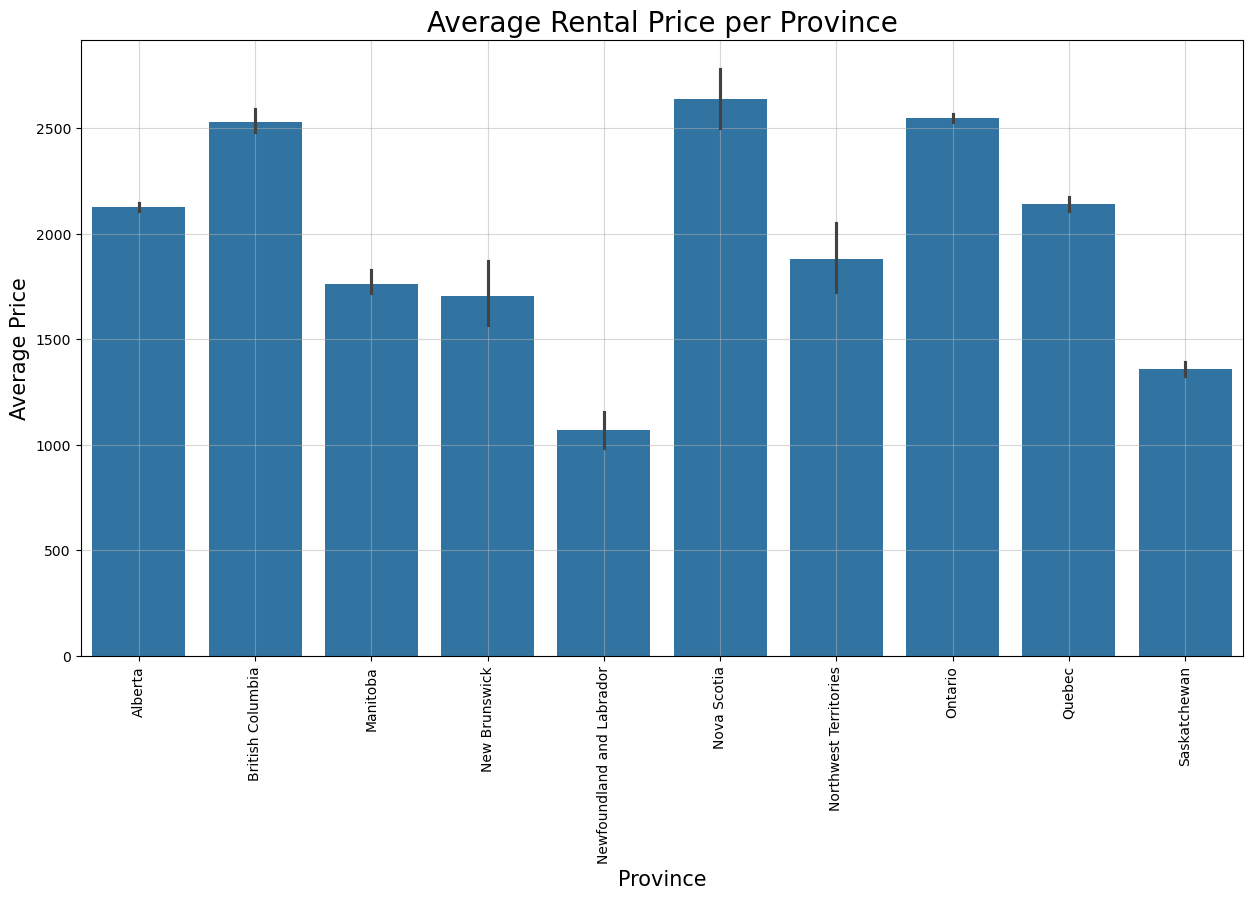

In [31]:
# visualize average price per province

plt.figure(figsize=(15,8))
sns.barplot(data=df, x='province', y='price', estimator='mean')
plt.title('Average Rental Price per Province', fontsize=20)
plt.xlabel('Province', fontsize=15)
plt.ylabel('Average Price', fontsize=15)
plt.grid(linestyle='-', alpha=0.5)
plt.xticks(rotation=90)
plt.show()

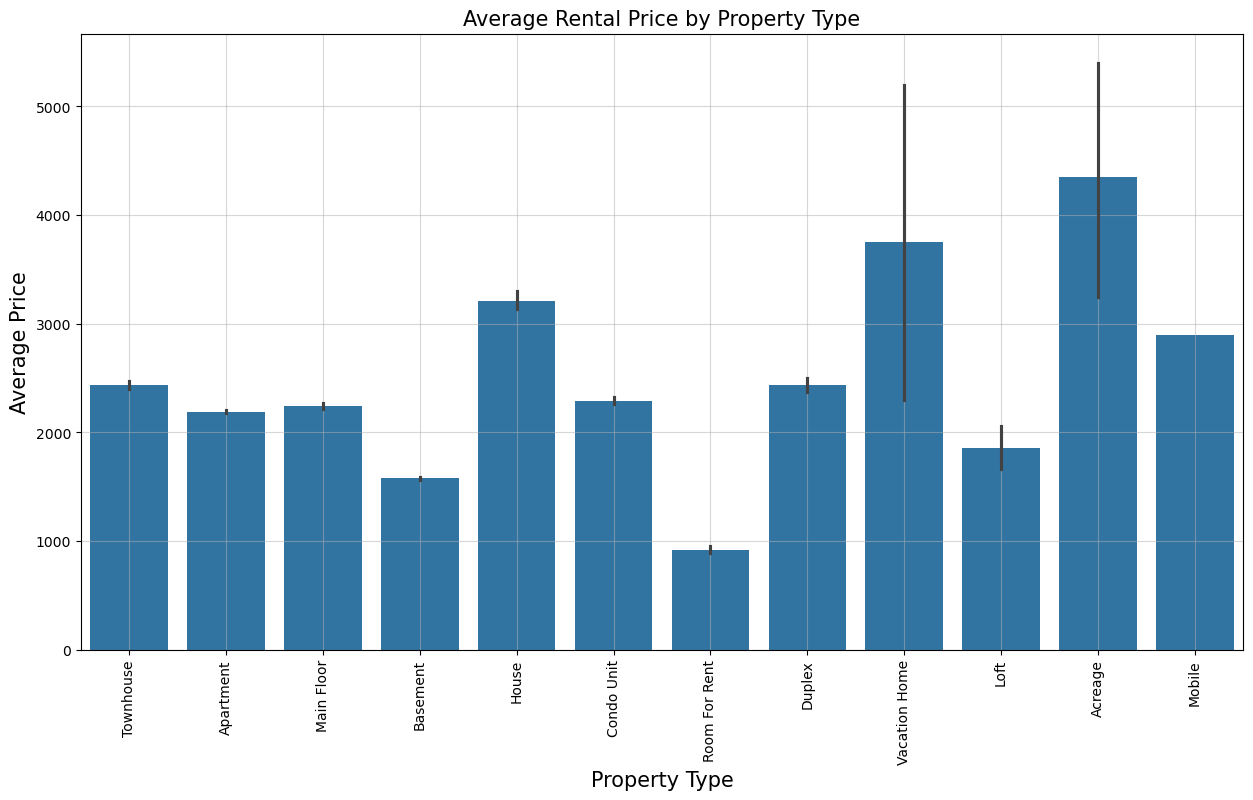

In [32]:
# visualize price per rental type

plt.figure(figsize=(15,8))
sns.barplot(data=df, x='type', y='price', estimator='mean')
plt.title('Average Rental Price by Property Type', fontsize=15)
plt.xlabel('Property Type', fontsize=15)
plt.ylabel('Average Price', fontsize=15)
plt.grid(linestyle='-', alpha=0.5)
plt.xticks(rotation=90)
plt.show()


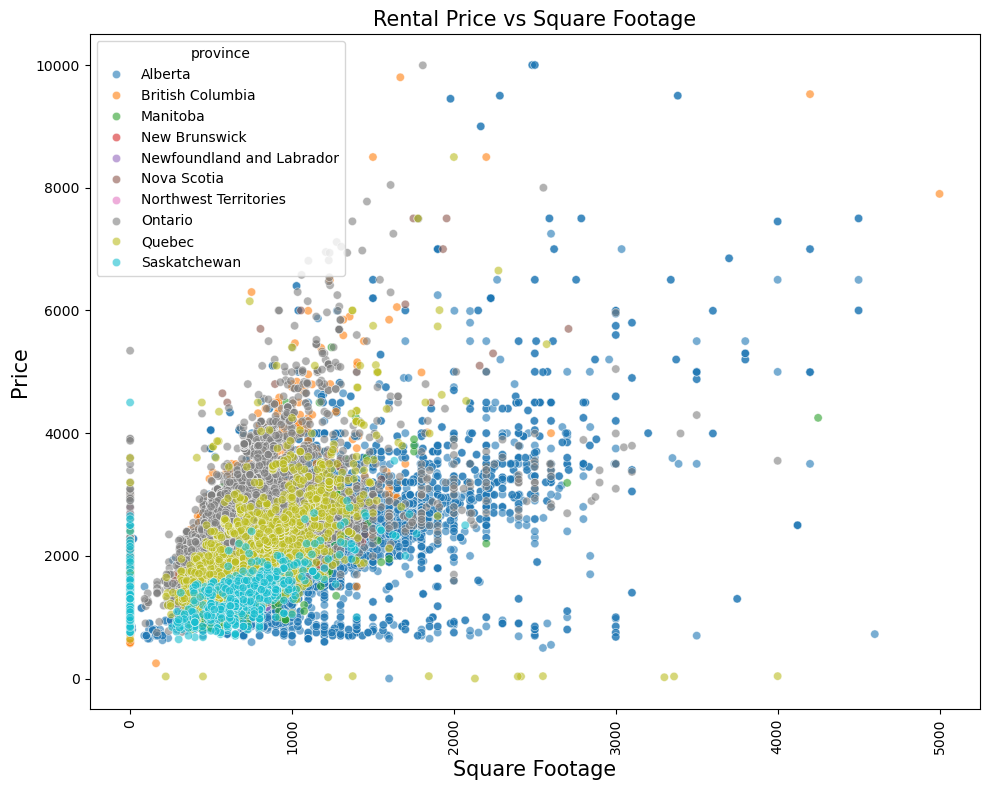

In [33]:
# visualize price vs sq ft

outlier_removed_df = df[(df['price'] <= 10000) & (df['sq_feet'] <= 5000)] # temporarly removing the outliers for better visuals

plt.figure(figsize=(10, 8))
sns.scatterplot(data=outlier_removed_df, x='sq_feet', y='price',  hue='province', alpha=0.6)
plt.title('Rental Price vs Square Footage', fontsize=15)
plt.xlabel('Square Footage', fontsize=15)
plt.ylabel('Price', fontsize=15)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


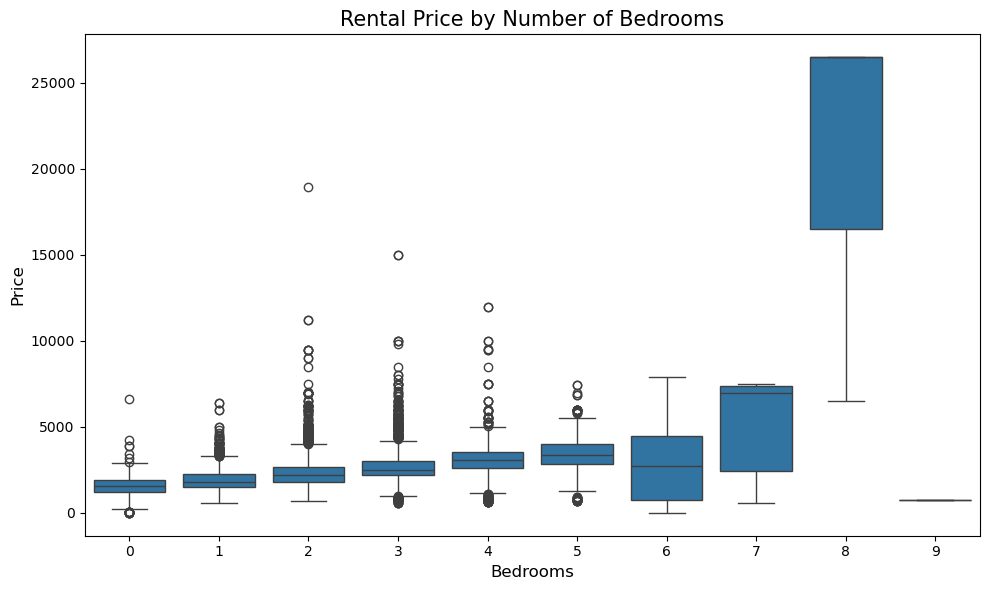

In [34]:
# visualize price per bedrooms

plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='beds', y='price')
plt.title('Rental Price by Number of Bedrooms', fontsize=15)
plt.xlabel('Bedrooms', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.tight_layout()
plt.show()


## Feature-Engineering

In [36]:
df

,city,province,latitude,longitude,lease_term,type,price,beds,baths,sq_feet,furnishing,availability_date,smoking,cats,dogs
0,Airdrie,Alberta,51.305962,-114.012515,Long Term,Townhouse,2495.0,2,2.5,1403.0,Unfurnished,Immediate,Non-Smoking,True,True
1,Airdrie,Alberta,51.305962,-114.012515,Long Term,Townhouse,2695.0,3,2.5,1496.0,Unfurnished,Immediate,Non-Smoking,True,True
2,Airdrie,Alberta,51.305962,-114.012515,Long Term,Townhouse,2295.0,2,2.5,1180.0,Unfurnished,Immediate,Non-Smoking,True,True
3,Airdrie,Alberta,51.305962,-114.012515,Long Term,Townhouse,2095.0,2,2.5,1403.0,Unfurnished,Future,Non-Smoking,True,True
4,Airdrie,Alberta,51.305962,-114.012515,Long Term,Townhouse,2495.0,2,2.5,1403.0,Unfurnished,Immediate,Non-Smoking,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25766,Yorkton,Saskatchewan,51.203024,-102.484782,Long Term,Apartment,920.0,0,1.0,400.0,Unfurnished,Immediate,Non-Smoking,True,True
25767,Yorkton,Saskatchewan,51.203024,-102.484782,Long Term,Apartment,1450.0,3,1.0,810.0,Unfurnished,Immediate,Non-Smoking,True,True
25768,Yorkton,Saskatchewan,51.202667,-102.485765,Long Term,Apartment,1125.0,1,1.0,520.0,Unfurnished,Immediate,Non-Smoking,True,True
25769,Yorkton,Saskatchewan,51.202667,-102.485765,Long Term,Apartment,920.0,0,1.0,400.0,Unfurnished,Immediate,Non-Smoking,True,True


In [37]:
# first take care of city. There are too many differnt options for onehotencoder

label_encoder=LabelEncoder()


df['city']=label_encoder.fit_transform(df['city'])
df['city']


0          1
1          1
2          1
3          1
4          1
        ... 
25766    236
25767    236
25768    236
25769    236
25770    236
Name: city, Length: 20632, dtype: int32

In [38]:
# OneHotEndoceer for the remaining categorical data
OHencoder = OneHotEncoder(drop='first', sparse_output = False)

encoded_cols = OHencoder.fit_transform(df[['province', 'lease_term', 'type', 'furnishing', 'availability_date', 'smoking', 'cats', 'dogs']])


#get_feature_names_out() returns the transformed feature names
encoded_df = pd.DataFrame(encoded_cols, columns = OHencoder.get_feature_names_out(['province', 'lease_term', 'type',
                                                                                 'furnishing', 'availability_date', 'smoking', 'cats', 'dogs']))
#add columns back to original df
df = df.drop(columns=['province', 'lease_term', 'type', 'furnishing', 'availability_date', 'smoking', 'cats', 'dogs']).join(encoded_df)

df.sample(5)

,city,latitude,longitude,price,beds,baths,sq_feet,province_British Columbia,province_Manitoba,province_New Brunswick,...,type_Room For Rent,type_Townhouse,type_Vacation Home,furnishing_Negotiable,furnishing_Unfurnished,availability_date_Immediate,smoking_Non-Smoking,smoking_Smoking Allowed,cats_True,dogs_True
17213,95,43.380971,-80.479799,2595.0,3,2.0,1200.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0
16938,94,44.248571,-76.565864,2745.0,2,2.0,1089.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0
1957,32,51.119328,-114.083843,2200.0,3,1.5,1300.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0
6919,63,53.515864,-113.507210,1950.0,2,2.0,900.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0
6660,63,53.419784,-113.600115,2800.0,4,2.5,2600.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0


## Finding Corrolations

In [40]:
correlation = df.corr()

correlation

,city,latitude,longitude,price,beds,baths,sq_feet,province_British Columbia,province_Manitoba,province_New Brunswick,...,type_Room For Rent,type_Townhouse,type_Vacation Home,furnishing_Negotiable,furnishing_Unfurnished,availability_date_Immediate,smoking_Non-Smoking,smoking_Smoking Allowed,cats_True,dogs_True
city,1.000000,-0.549625,0.555922,0.083946,-0.242878,-0.202203,-0.270357,-0.112568,-0.142312,-0.017493,...,-0.056357,-0.101071,-0.009860,-0.062254,0.091945,0.174841,0.052577,-0.039541,0.177250,0.167173
latitude,-0.549625,1.000000,-0.886978,-0.249815,0.207111,0.169121,0.150593,0.186247,0.083725,0.010160,...,0.070924,0.069586,0.009757,0.060826,-0.120675,-0.105684,-0.039445,0.023503,-0.176529,-0.173547
longitude,0.555922,-0.886978,1.000000,0.131122,-0.220890,-0.194610,-0.184749,-0.129145,-0.112829,-0.013879,...,-0.083976,-0.081572,-0.009127,-0.077483,0.146355,0.147598,0.049660,-0.031172,0.222680,0.211801
price,0.083946,-0.249815,0.131122,1.000000,0.433878,0.519028,0.508363,-0.118395,-0.003457,0.002246,...,-0.011046,-0.000945,-0.014047,0.000729,0.019392,0.016889,-0.003577,0.010676,0.044258,0.046556
beds,-0.242878,0.207111,-0.220890,0.433878,1.000000,0.680790,0.699412,-0.025807,0.046869,0.006264,...,0.014955,0.022405,-0.013850,0.020700,-0.030659,-0.009788,-0.016150,0.031966,-0.049225,-0.044068
baths,-0.202203,0.169121,-0.194610,0.519028,0.680790,1.000000,0.692937,-0.051906,0.036365,0.009750,...,0.012911,0.025679,-0.011043,0.013587,-0.024968,-0.019917,-0.015113,0.024602,-0.030245,-0.026275
sq_feet,-0.270357,0.150593,-0.184749,0.508363,0.699412,0.692937,1.000000,-0.022789,0.071803,0.014831,...,0.006339,0.022400,0.004529,0.015912,-0.028511,-0.019367,-0.024058,0.033270,-0.051743,-0.043748
province_British Columbia,-0.112568,0.186247,-0.129145,-0.118395,-0.025807,-0.051906,-0.022789,1.000000,-0.043058,-0.005293,...,-0.029553,-0.047455,-0.003528,-0.021626,0.032369,0.024797,-0.001469,-0.008799,0.033828,0.037416
province_Manitoba,-0.142312,0.083725,-0.112829,-0.003457,0.046869,0.036365,0.071803,-0.043058,1.000000,-0.004482,...,-0.025024,-0.009394,-0.002987,-0.024133,0.053807,-0.100221,-0.193758,0.267314,0.059149,0.026874
province_New Brunswick,-0.017493,0.010160,-0.013879,0.002246,0.006264,0.009750,0.014831,-0.005293,-0.004482,1.000000,...,-0.003076,-0.006150,-0.000367,-0.002966,0.007331,0.019747,0.002296,-0.001727,-0.023579,-0.021241


In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20632 entries, 0 to 25770
Data columns (total 36 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   city                                20632 non-null  int32  
 1   latitude                            20632 non-null  float64
 2   longitude                           20632 non-null  float64
 3   price                               20632 non-null  float64
 4   beds                                20632 non-null  int64  
 5   baths                               20632 non-null  float64
 6   sq_feet                             20632 non-null  float64
 7   province_British Columbia           16346 non-null  float64
 8   province_Manitoba                   16346 non-null  float64
 9   province_New Brunswick              16346 non-null  float64
 10  province_Newfoundland and Labrador  16346 non-null  float64
 11  province_Northwest Territories      16346 non-

In [42]:
df.isnull().sum()

city                                     0
latitude                                 0
longitude                                0
price                                    0
beds                                     0
baths                                    0
sq_feet                                  0
province_British Columbia             4286
province_Manitoba                     4286
province_New Brunswick                4286
province_Newfoundland and Labrador    4286
province_Northwest Territories        4286
province_Nova Scotia                  4286
province_Ontario                      4286
province_Quebec                       4286
province_Saskatchewan                 4286
lease_term_Long Term                  4286
lease_term_Short Term                 4286
type_Apartment                        4286
type_Basement                         4286
type_Condo Unit                       4286
type_Duplex                           4286
type_House                            4286
type_Loft  

In [43]:
df = df.dropna(how='any',axis=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16346 entries, 0 to 20631
Data columns (total 36 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   city                                16346 non-null  int32  
 1   latitude                            16346 non-null  float64
 2   longitude                           16346 non-null  float64
 3   price                               16346 non-null  float64
 4   beds                                16346 non-null  int64  
 5   baths                               16346 non-null  float64
 6   sq_feet                             16346 non-null  float64
 7   province_British Columbia           16346 non-null  float64
 8   province_Manitoba                   16346 non-null  float64
 9   province_New Brunswick              16346 non-null  float64
 10  province_Newfoundland and Labrador  16346 non-null  float64
 11  province_Northwest Territories      16346 non-

In [44]:
#Find the top correlations to Price

correlation = df.corr(numeric_only=True)  # Ensure only numeric columns
top_corr = correlation['price'].drop('price').abs().sort_values(ascending=False).head(10)
print(top_corr)


baths                        0.535671
sq_feet                      0.531570
beds                         0.433578
province_Saskatchewan        0.270341
latitude                     0.256439
longitude                    0.140489
province_British Columbia    0.118395
city                         0.105858
province_Quebec              0.079449
type_Apartment               0.070556
Name: price, dtype: float64


# Regression Models

## 1. Linear Regression

In [47]:
# finding price
X = df.drop("price", axis=1)
y = df['price']

In [48]:
#test/train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 1)


In [49]:
## Scale features
scaler_slr = StandardScaler()
scaled_X_train = scaler_slr.fit_transform(X_train)
scaled_X_test= scaler_slr.transform(X_test) 

In [50]:
from sklearn.linear_model import LinearRegression

slr_model = LinearRegression()

slr_model.fit(scaled_X_train, y_train)

LinearRegression()

In [51]:
y_pred = slr_model.predict(X_test)

# Obtain metrics

MAE = mean_absolute_error(y_test, y_pred)
MSE = mean_squared_error(y_test, y_pred)
RMSE = np.sqrt(MSE)
R2 = r2_score(y_test, y_pred)

print("MAE: ", mean_absolute_error(y_test, y_pred))
print("MSE: ", mean_squared_error(y_test, y_pred))
print("RMSE: ", str(RMSE))
print("R2: ", r2_score(y_test, y_pred))
# Very bad results - maybe try with selected features

MAE:  292716.4596881935
MSE:  114953838961.6982
RMSE:  339048.431587138
R2:  -107603.96870328224


C:\Users\Jon\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


## Trying a Second Linear Regression Model with Selected Features

In [53]:
top_features = ['baths', 'sq_feet', 'beds', 'province_Saskatchewan', 'latitude', 'longitude']
df_top = df[top_features + ['price']].copy()
df_top

,baths,sq_feet,beds,province_Saskatchewan,latitude,longitude,price
0,2.5,1403.0,2,0.0,51.305962,-114.012515,2495.00
1,2.5,1496.0,3,0.0,51.305962,-114.012515,2695.00
2,2.5,1180.0,2,0.0,51.305962,-114.012515,2295.00
3,2.5,1403.0,2,0.0,51.305962,-114.012515,2095.00
4,2.5,1403.0,2,0.0,51.305962,-114.012515,2495.00
...,...,...,...,...,...,...,...
20627,2.0,922.0,3,1.0,43.643157,-79.428961,3773.00
20628,2.0,780.0,2,1.0,43.643157,-79.428961,3313.00
20629,1.0,457.0,0,1.0,43.643157,-79.428961,2012.00
20630,1.0,477.0,0,1.0,43.643157,-79.428961,1817.00


In [75]:
# finding price
X1 = df_top.drop("price", axis=1)
y1 = df_top['price']

In [77]:
#test/train
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size = 0.1, random_state = 1)


In [79]:
from sklearn.linear_model import LinearRegression

slr_model_feat = LinearRegression()

slr_model_feat.fit(X_train1, y_train1)

LinearRegression()

In [81]:
y_pred1 = slr_model_feat.predict(X_test1)

# Obtain metrics

MAE = mean_absolute_error(y_test1, y_pred1)
MSE = mean_squared_error(y_test1, y_pred1)
RMSE = np.sqrt(MSE)
R2 = r2_score(y_test, y_pred)

print("MAE: ", mean_absolute_error(y_test1, y_pred1))
print("MSE: ", mean_squared_error(y_test1, y_pred1))
print("RMSE: ", str(RMSE))
print("R2: ", r2_score(y_test1, y_pred1))
# So much better with Selected Features

MAE:  402.32490290926006
MSE:  525935.6104678963
RMSE:  725.2141824784567
R2:  0.5076868644361142


## 2. Polynomial Regression

In [59]:
# finding price
X = df.drop("price", axis=1)
y = df['price']

In [60]:
poly_converter = PolynomialFeatures(degree=2, include_bias=False) 

# Fit converter to X features + transform features

poly_features = poly_converter.fit_transform(X)

In [61]:
X.shape, poly_features.shape


((16346, 35), (16346, 665))

In [62]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(poly_features, y, test_size=0.10, random_state=1)

# Create instance of model
poly_model = LinearRegression()

# Train regression model
poly_model.fit(X_train, y_train)


LinearRegression()

In [63]:
y_pred = poly_model.predict(X_test)

# Obtain metrics

MAE = mean_absolute_error(y_test, y_pred)
MSE = mean_squared_error(y_test, y_pred)
RMSE = np.sqrt(MSE)
R2 = r2_score(y_test, y_pred)


print("MAE: ", mean_absolute_error(y_test, y_pred))
print("MSE: ", mean_squared_error(y_test, y_pred))
print("RMSE: ", str(RMSE))
print("R2: ", r2_score(y_test, y_pred))
# Those are very bad results - This would be better with selected features

MAE:  3387114.8294740617
MSE:  1.8753509031832064e+16
RMSE:  136943451.9494527
R2:  -17554618188.996975


## 3. Lasso Cross Validation

In [65]:
# LassoCV model
X = df.drop("price", axis=1)
y = df['price']
# Create instance of model
lassocv_model = LassoCV(eps=0.01,n_alphas=5,cv=10, max_iter=10000)


# Scale features
scaler_lasso = StandardScaler()
X_train = scaler_lasso.fit_transform(X_train)
X_test= scaler_lasso.transform(X_test) 


# Fit the model 
lassocv_model.fit(X_train, y_train) # already scaled

LassoCV(cv=10, eps=0.01, max_iter=10000, n_alphas=5)

In [66]:

lassocv_model.alpha_

5.271582161204277

In [67]:
# lassocv coefficients

lassocv_model.coef_

# all the "0" coeffiecients means the model is not considereing them

array([-0.00000000e+00, -0.00000000e+00, -0.00000000e+00,  1.46687353e+02,
        1.74560660e+02,  0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
        0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        0.00000000e+00, -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
        0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
       -1.59013174e+01,  0.00000000e+00,  4.24500643e+01,  1.27856889e+01,
        0.00000000e+00, -1.73593782e+01, -0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,  4.43071699e+01,
        1.29028659e+02, -0.00000000e+00, -0.00000000e+00, -3.52561210e-01,
       -0.00000000e+00, -

In [68]:
# lassocv metrics

y_pred = lassocv_model.predict(X_test) # already scaled

# Obtain metrics

MAE = mean_absolute_error(y_test, y_pred)
MSE = mean_squared_error(y_test, y_pred)
RMSE = np.sqrt(MSE)

print("MAE: ", mean_absolute_error(y_test, y_pred))
print("MSE: ", mean_squared_error(y_test, y_pred))
print("RMSE: ", str(RMSE))
print("R2: ", r2_score(y_test, y_pred))
#That seems very reasonable

MAE:  378.3976245155943
MSE:  366043.39534448733
RMSE:  605.0152025730323
R2:  0.6573573492120559


### Chosen for final model 
The Lasso Cross Validation model does have the best  MAE of only $378 and higher R2 score and preformed better. The Linear Regression model with selected features was chosen for the final model for predictions as it was close to the same MAE and R2 score but was much more reasonable to fill out new data.

##  Final Model with New Predictions

In [71]:
X1.columns.tolist()

['baths', 'sq_feet', 'beds', 'province_Saskatchewan', 'latitude', 'longitude']

In [95]:
new_listing = pd.DataFrame([{ # Fill in all this manually. in Alberta this is priced at $1349
    'baths': 1.0,
    'sq_feet': 842,
    'beds': 2.0,
    'province_Saskatchewan': 0,
    'latitude': 53.4901,
    'longitude': -113.5418,}])

In [97]:
predicted_price = slr_model_feat.predict(new_listing)


In [99]:
print(f"Predicted Price: ${predicted_price[0]:.2f}")

Predicted Price: $1566.49


Actual listing $1349 which seems on the low side anyways so this is quite accurate.